In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
from math import log10

**SE OBTIENE EL DATASET**




In [192]:
#new_data=pd.read_csv('/content/drive/MyDrive/Colabs Intro a Señales/Labs de Intro a Señales/Lab 8/rec_1.csv',skiprows=[1], quotechar="'", index_col=0)
#print(new_data)

[445.38610355 449.03895086 454.08879696 ...   0.           0.
   0.        ]


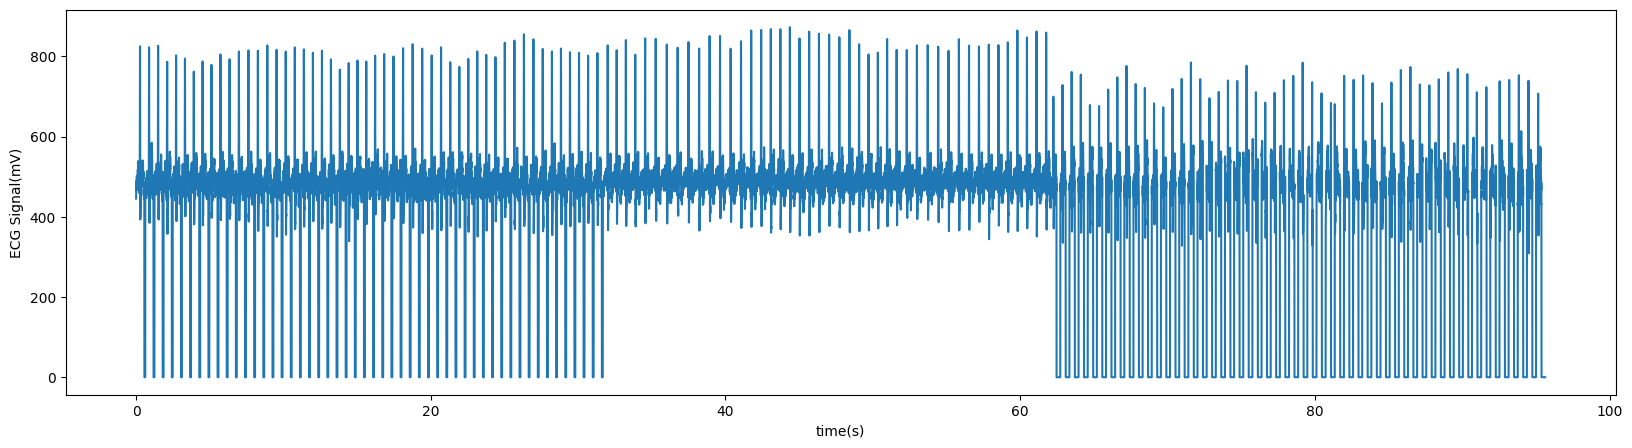

In [193]:
# A numpy
#t = pd.to_datetime(new_data.index)
#td = t - t.min()
#mtime = td.total_seconds()
#voltaje = new_data.to_numpy()
voltaje = np.loadtxt('/content/drive/MyDrive/Colabs Intro a Señales/Labs de Intro a Señales/Lab 8/Señales_juntas.txt')
voltaje = voltaje.flatten()
print(voltaje)
#voltaje = array1[:,-2]
#voltaje

fs = 1000
T = 1/fs
n = np.arange(0,voltaje.shape[0])
mtime =  n*T

plt.figure(figsize=(20,5))
plt.plot(mtime, voltaje)
plt.ylabel('ECG Signal(mV)')
plt.xlabel('time(s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

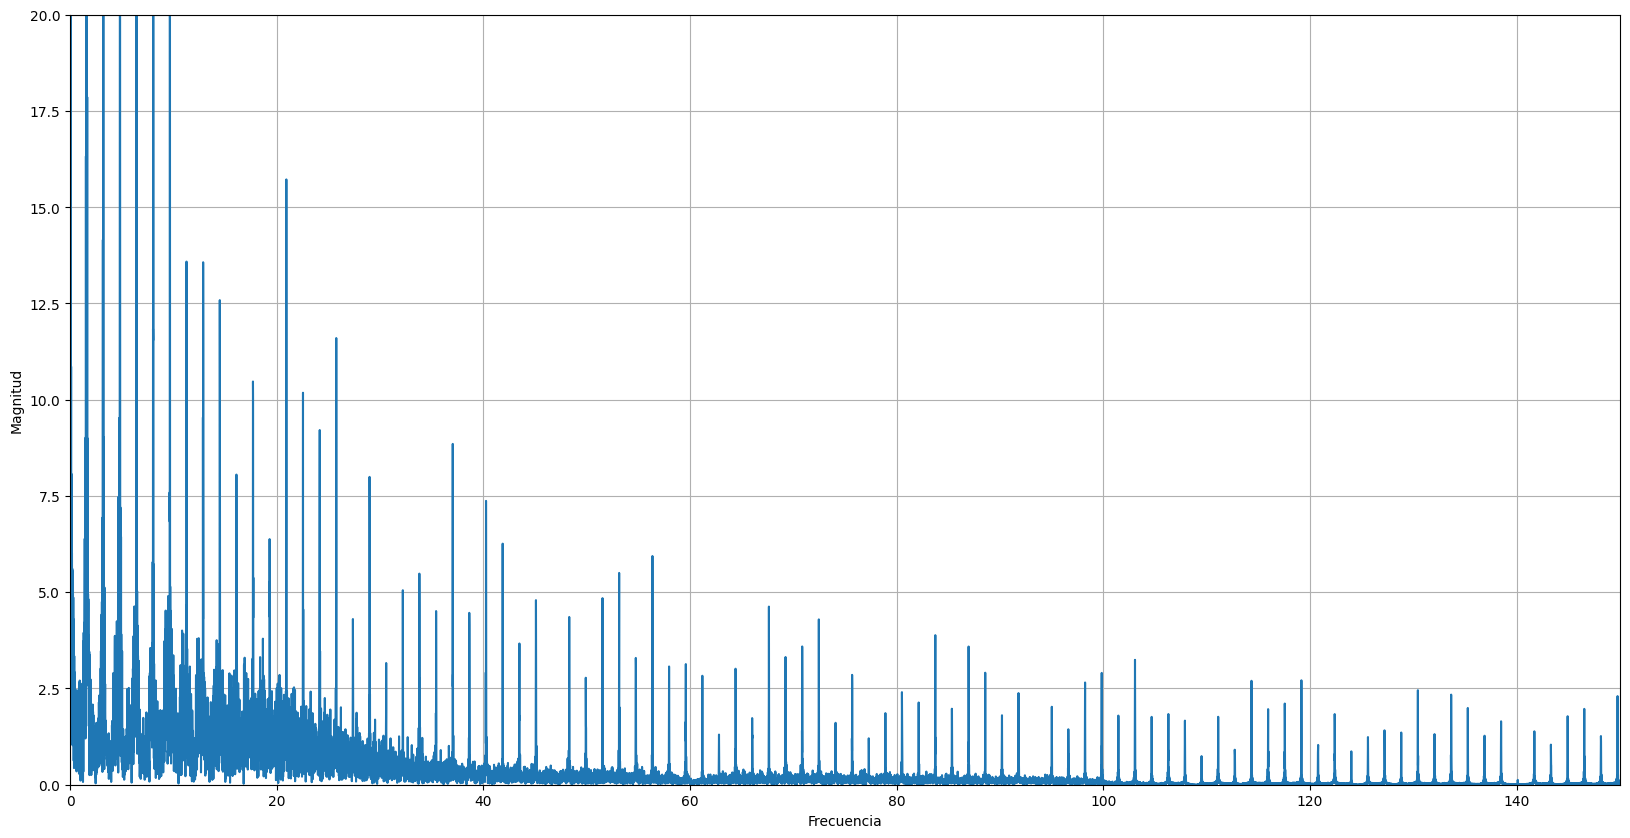

In [194]:
# Analizar el Fourier
ecg_senal = voltaje
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 1/fs
N = len(ecg_senal)
yf = fft(ecg_senal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.xlim(0,150)
plt.ylim(0,20)
plt.show()

En el gráfico anterior, existe ruido que se debe filtrar.

Se propone utilizar filtros digitales Notch para el ruido de la red electrica



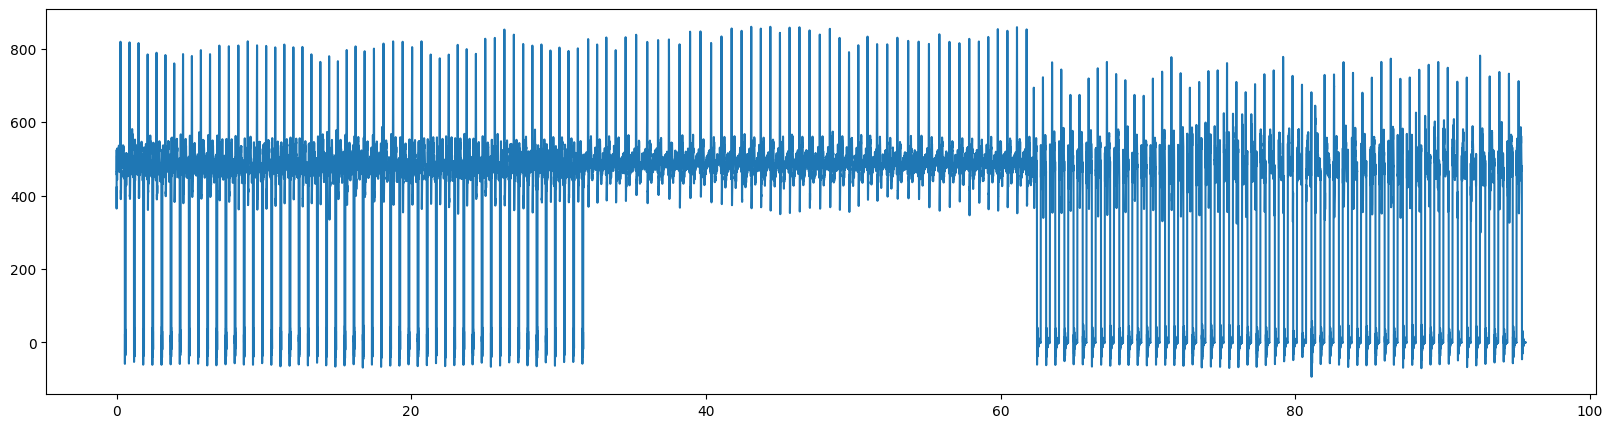

In [195]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 60.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_senal)
y = lfilter(b, a, y)
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 80.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)
plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(mtime,y)
plt.show()

Regresamos a verificar las atenuaciones de los filtros en frecuencia

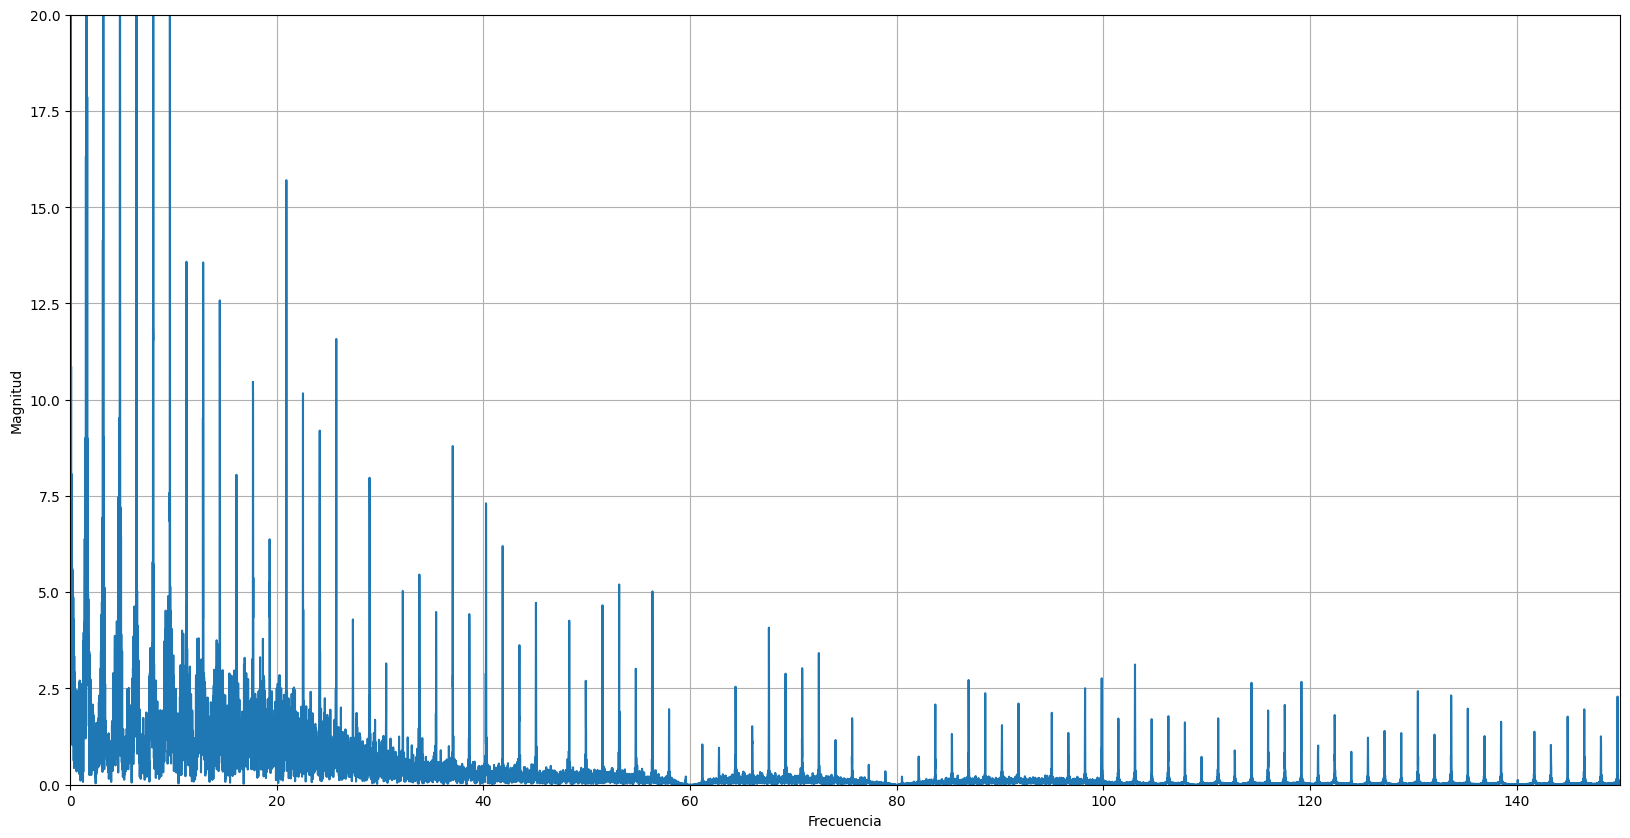

In [196]:
# Analisis de Fourier de los filtros
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
#T = 0.002
N = len(y)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.xlim(0,150)
plt.ylim(0,20)
plt.show()
ecg_signal = y

**FILTRADO DE PASA BANDA DEL CODIGO DE LA CLASE**

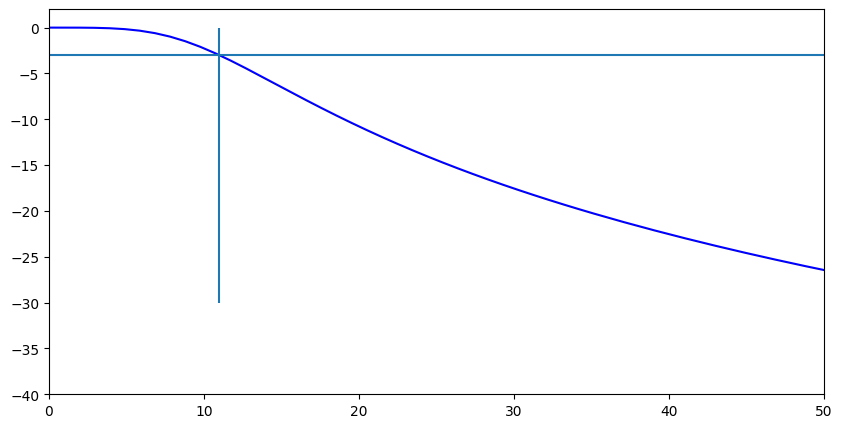

In [197]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=1000)
w, h = freqz(b, a, fs=1000)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

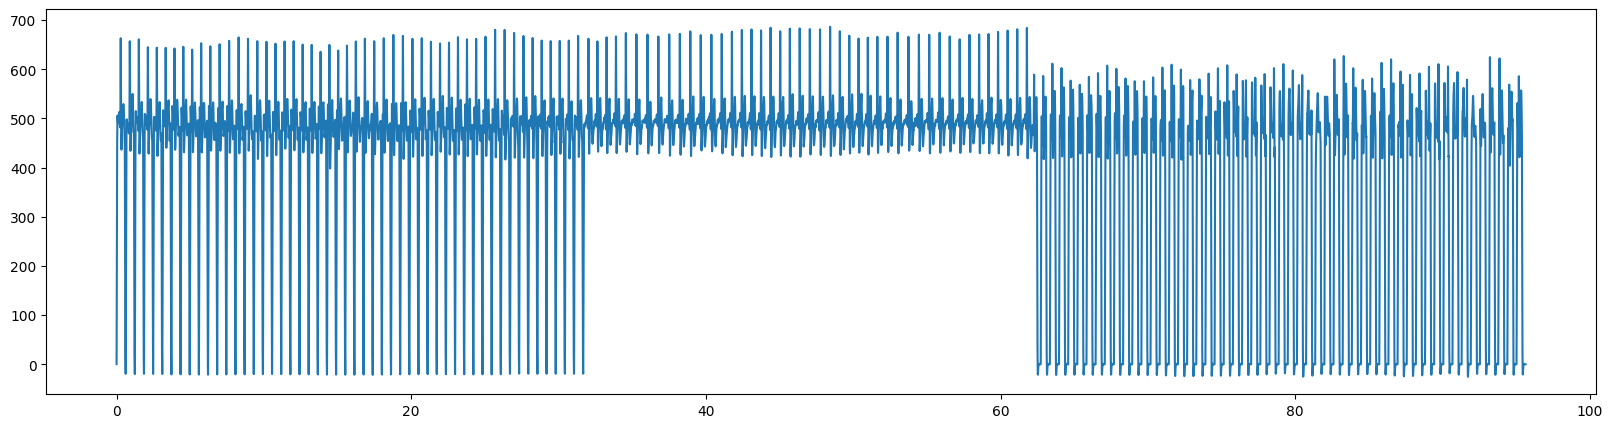

In [198]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpb_signal)
plt.show()

**FILTRO PASA ALTO DEL CODIGO DE LA CLASE**

<ipython-input-199-ad1bb2aa6391>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


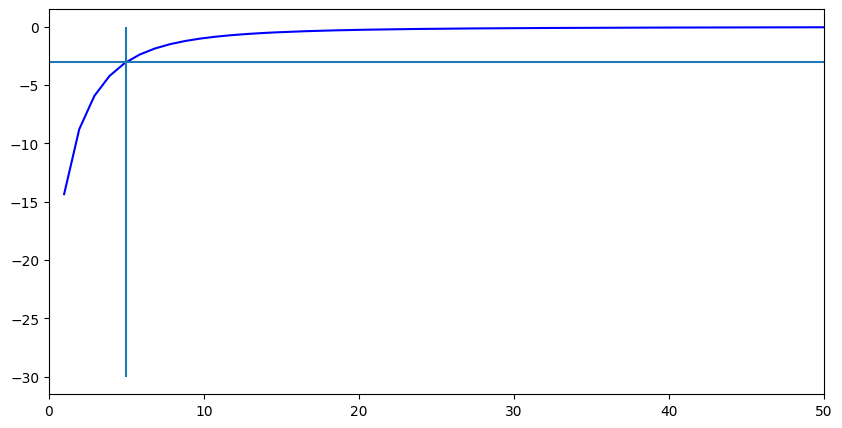

In [199]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=1000)
w, h = freqz(b, a, fs=1000)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


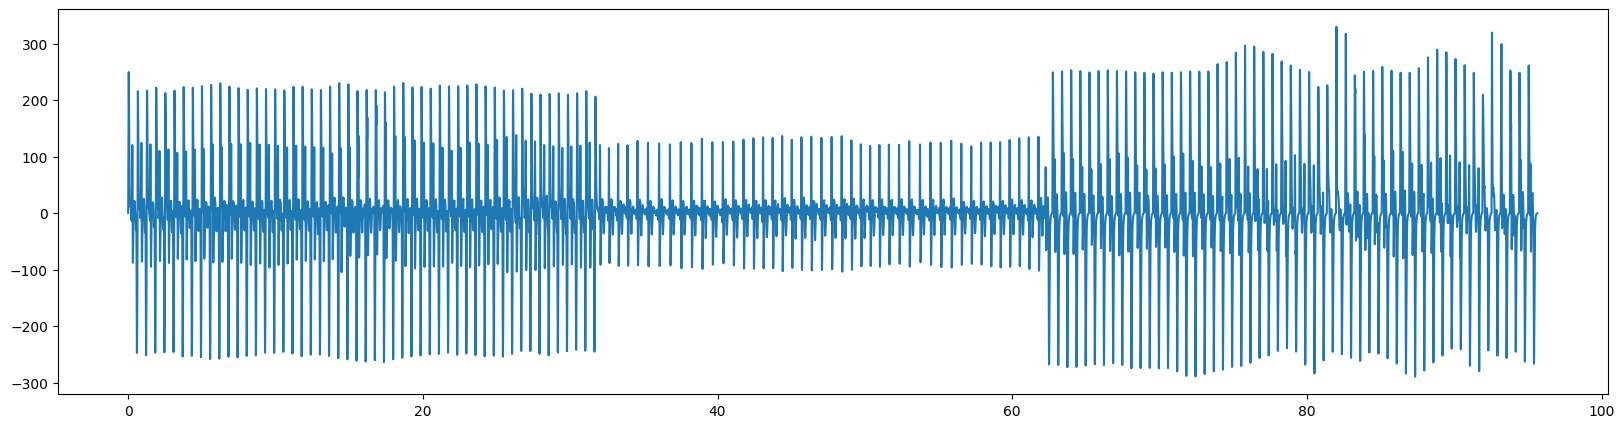

In [200]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpa_signal)
plt.show()

**FILTRO PROPIO PASA BAJO**

<ipython-input-201-a90c4fdfabba>:14: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h))


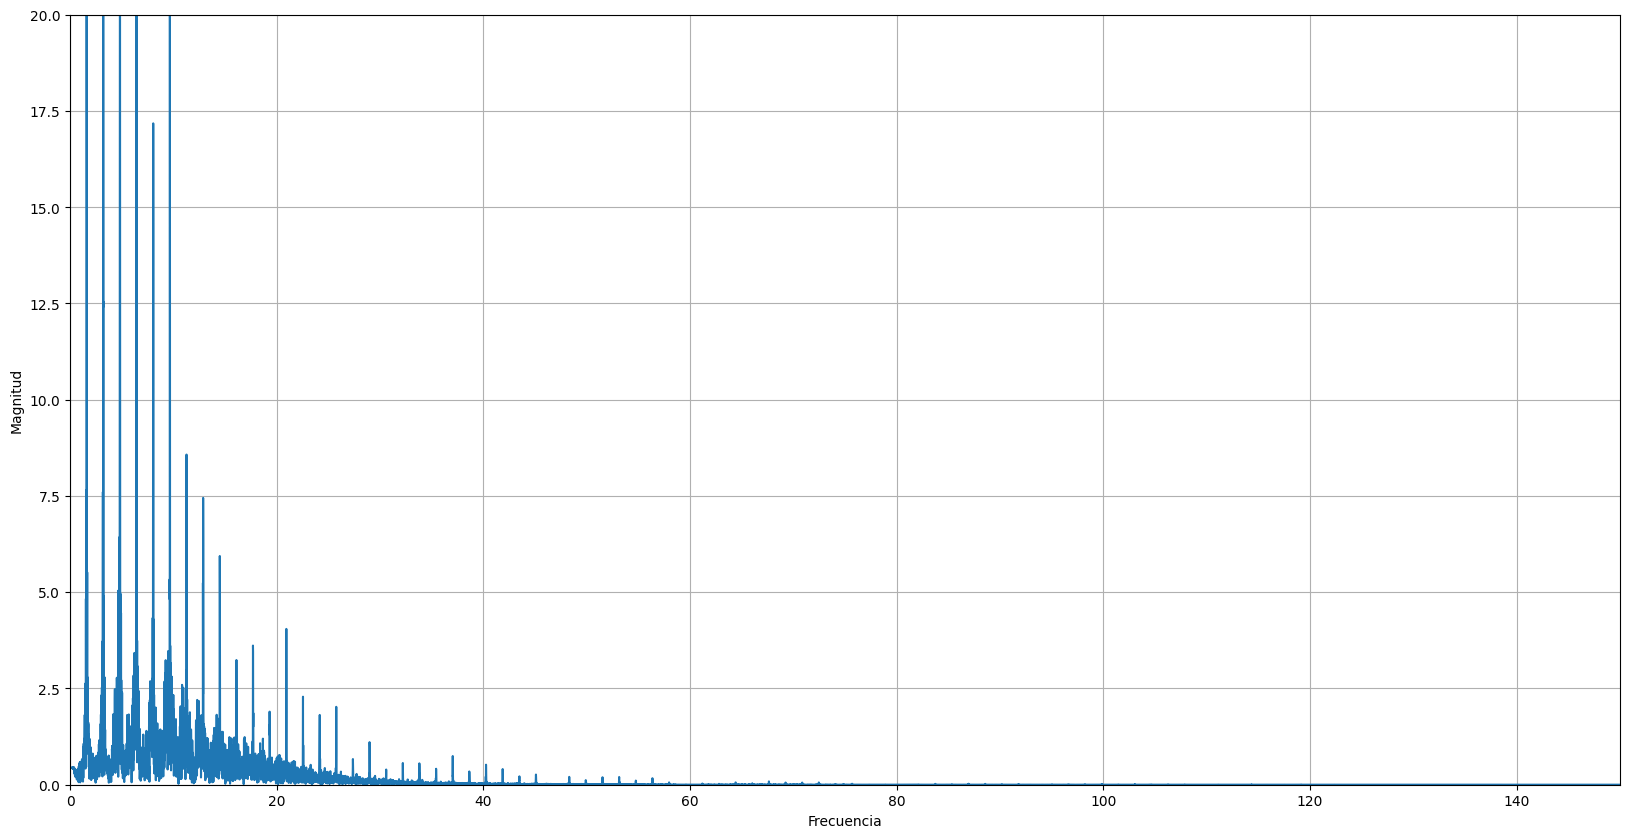

In [201]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
#Especificaciones del filtro
fc1 = 0.5  # frecuencia de corte inferior
fc2 = 100  # frecuencia de corte superior
order = 2  # orden del filtro


#Diseñar filtro
b, a = signal.butter(order, [fc1/(fs/2), fc2/(fs/2)], btype='bandpass')
w, h = signal.freqz(b, a, worN=8000)
f = w / (2 * np.pi) * fs
db = 20 * np.log10(abs(h))

#Aplicando filtro IIR
fpa_signal = signal.filtfilt(b, a, fpa_signal)

#Mostrar espectro de frecuencia
T = 1/fs
N = len(fpa_signal)
yf = fft(fpa_signal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.xlim(0,150)
plt.ylim(0,20)
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4]) 

Por lo tanto:

b=[−1,−2,0,2,1]

<ipython-input-202-e4428ba3d9cf>:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


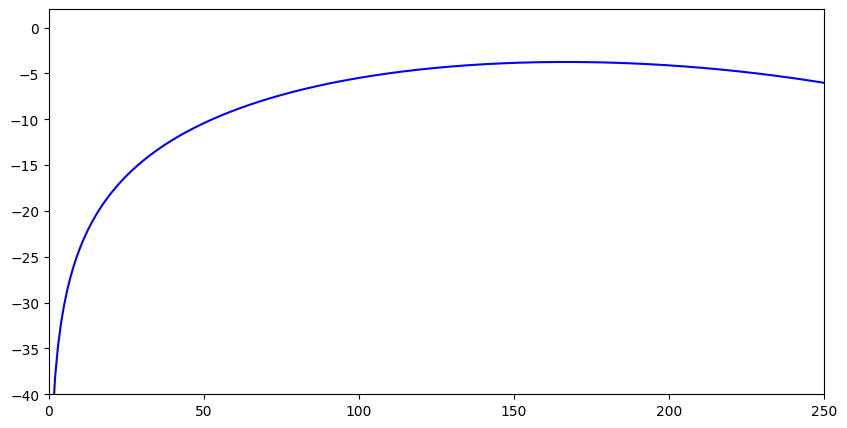

In [202]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=1000)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

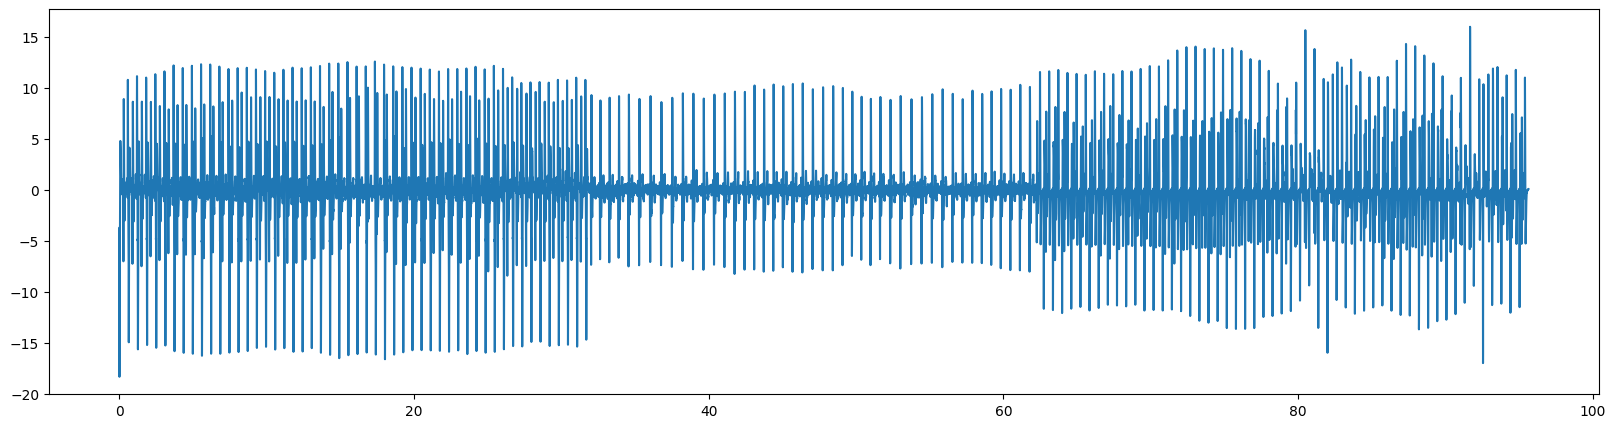

In [203]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fd_signal)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

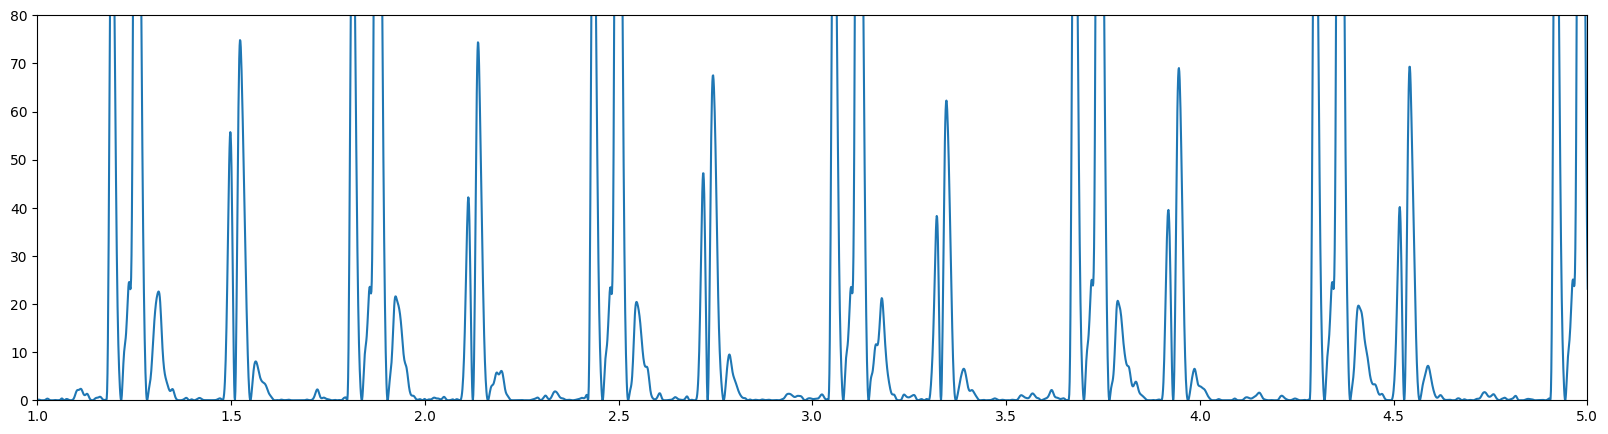

In [204]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime, f_sq)
plt.xlim(1,5)
plt.ylim(0,80)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

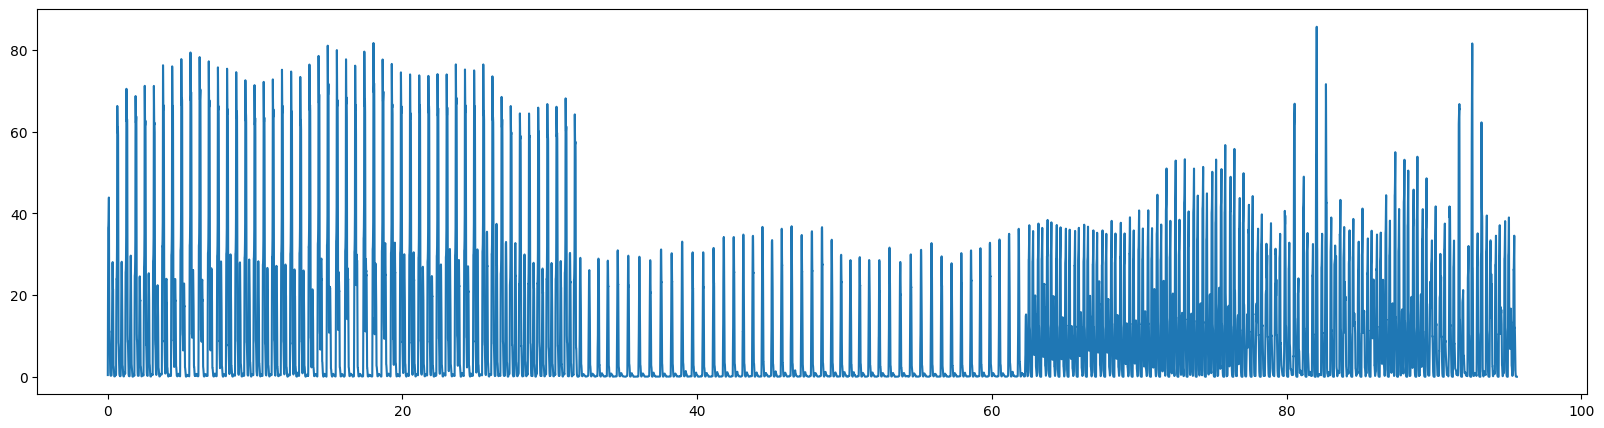

In [205]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(mtime,fi_signal)
plt.show()

Colocando marcadores en los picos

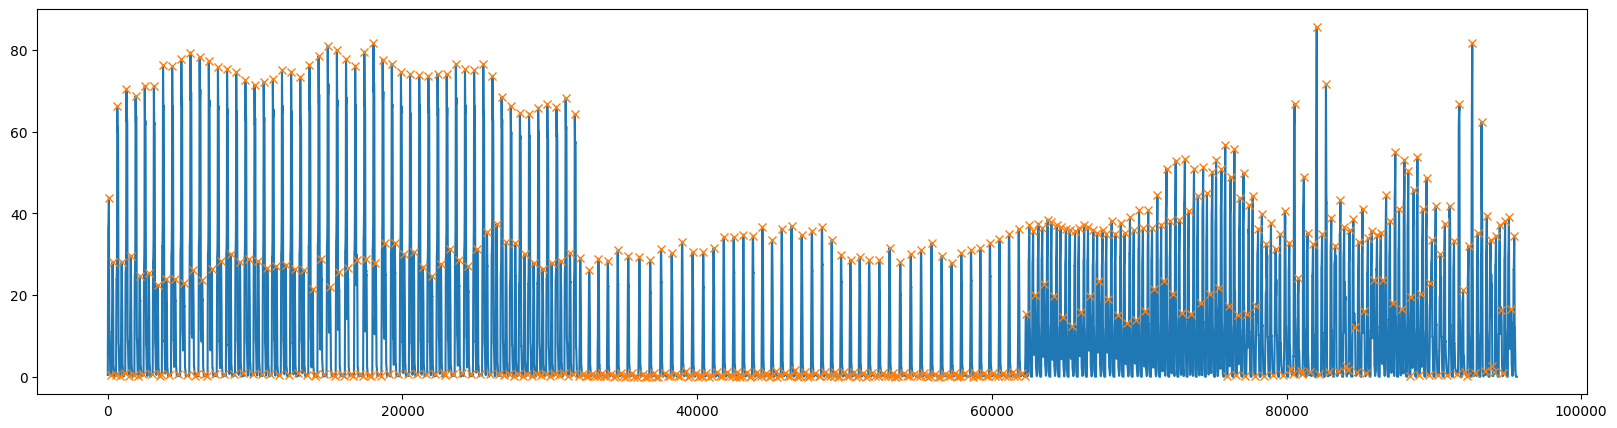

In [206]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=100)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  21.406671578442186
El valor del umbral de ruido de entrada es  10.858136456265285


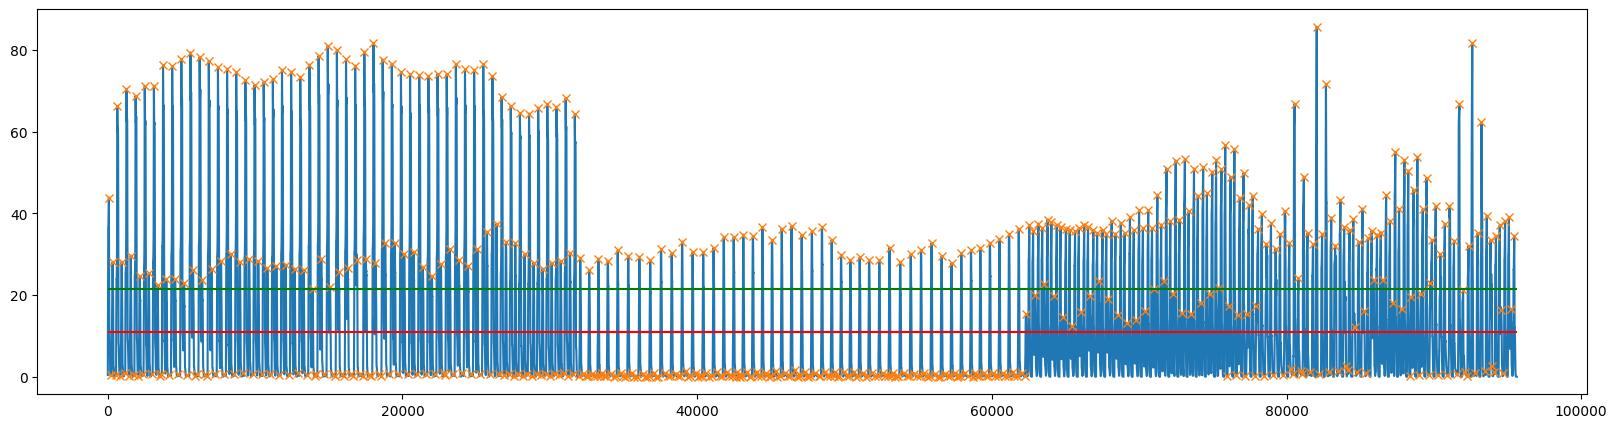

In [207]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.25
th_I2 = 0.5*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

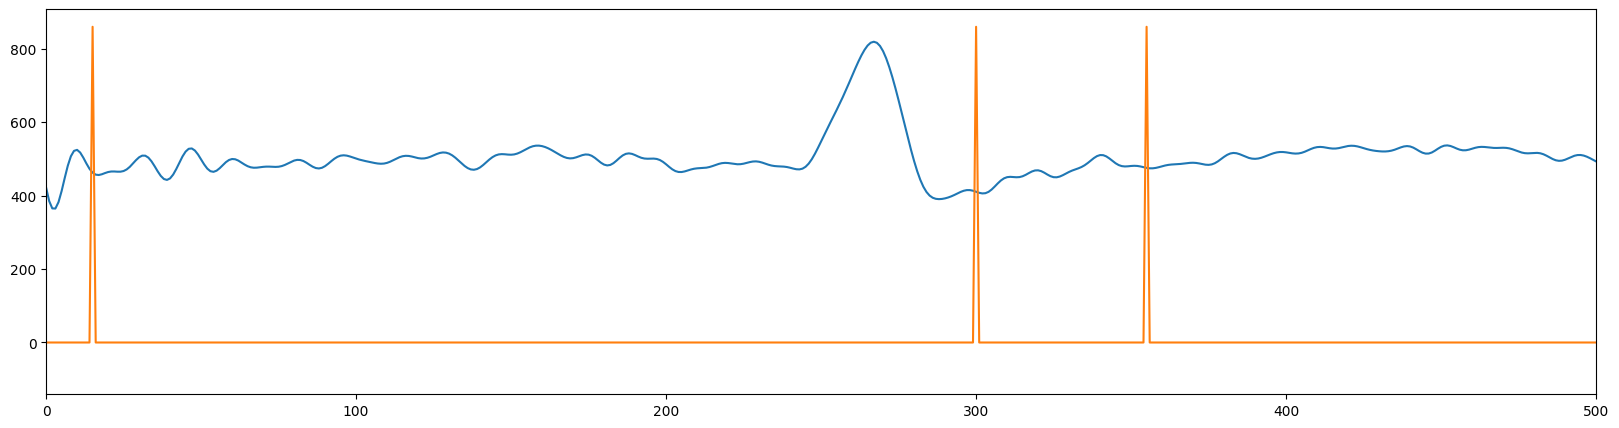

In [208]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.xlim(0,500)
plt.plot(ecg_signal)
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

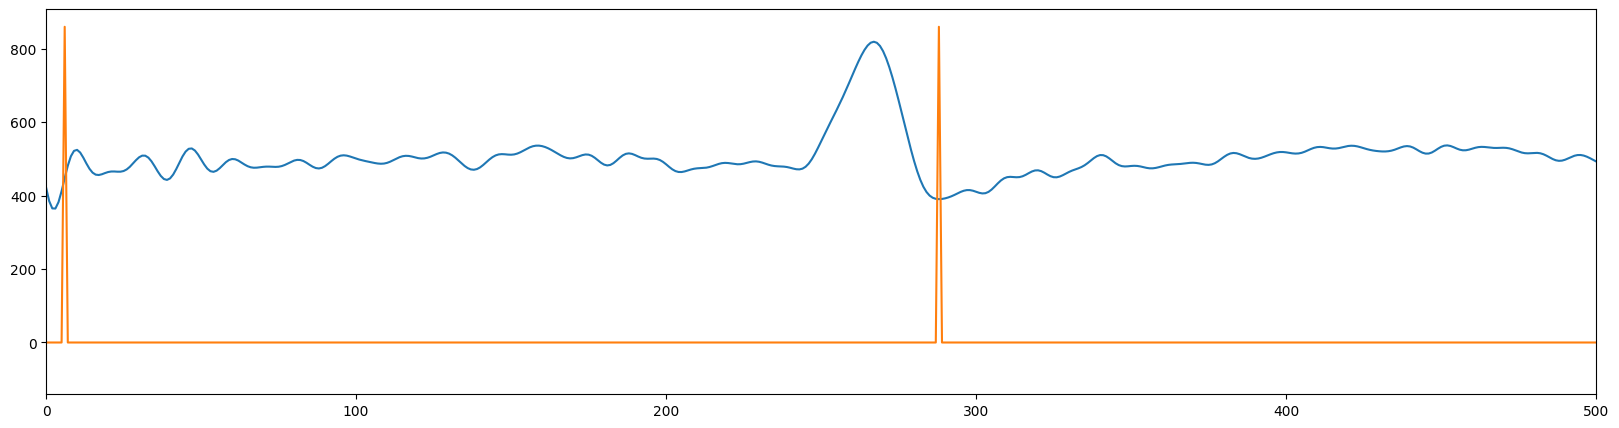

In [209]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(0,500)
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

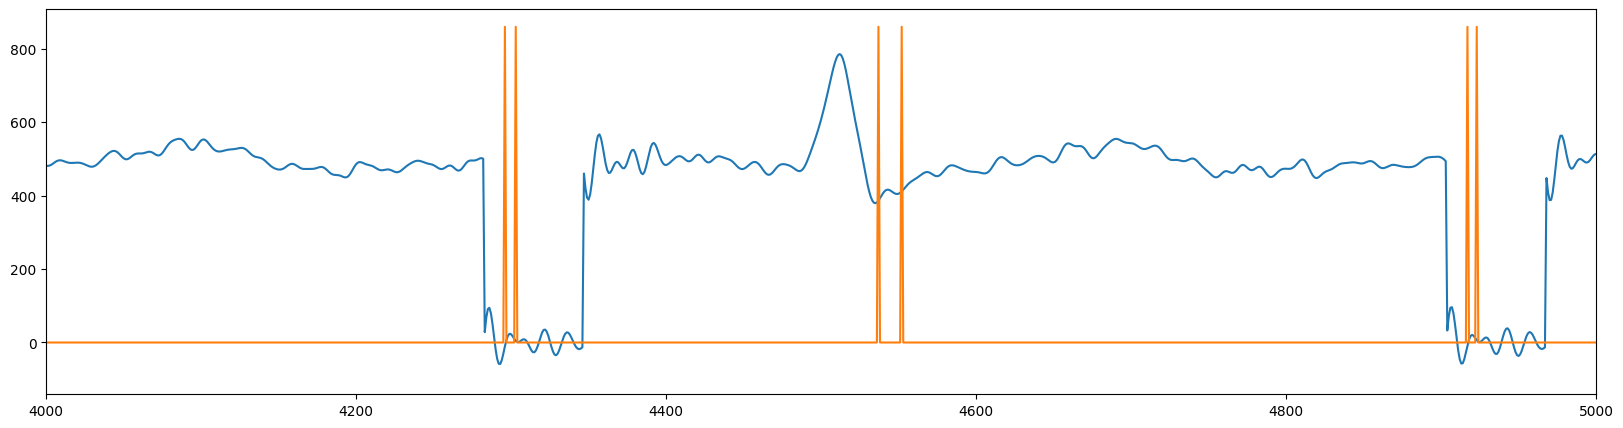

In [210]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.xlim(4000,5000)
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()


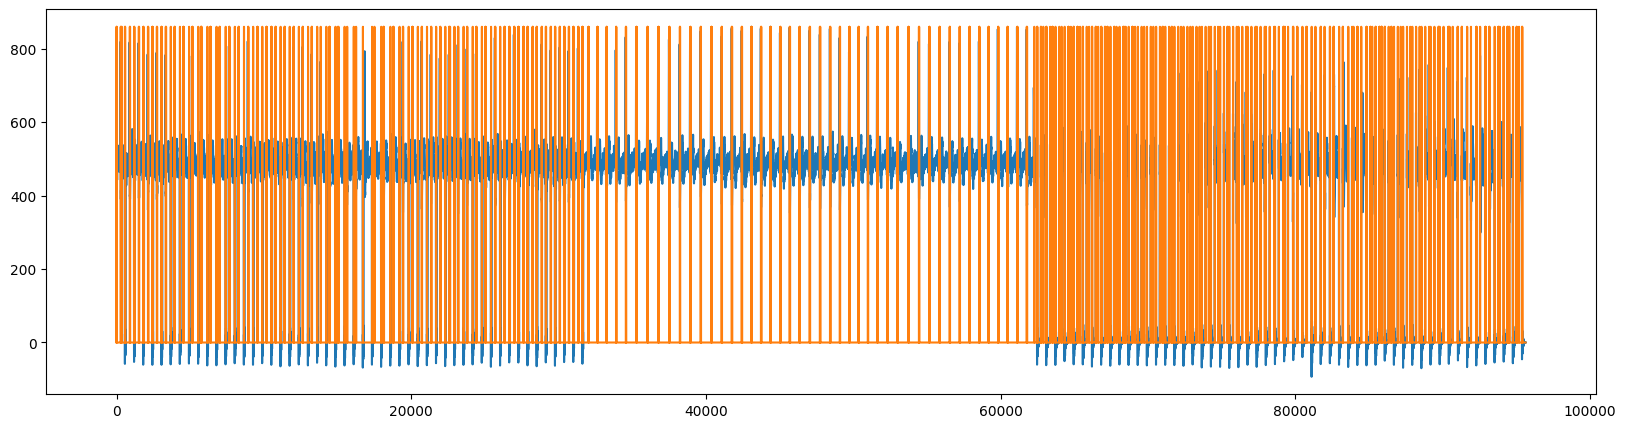

In [211]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()